# Introduction

## Business Problem
Used car marketplaces need reliable price estimation to improve transparency, reduce negotiation friction, and accelerate sales. This EDA identifies price drivers to guide the regression notebook.

## Key Findings
- Price distribution is right-skewed with high-value outliers.
- Strong relationships with odometer (mileage), age, and engine displacement/power.
- Brand, fuel type, and transmission segment price bands distinctly.

## Methodology
1. Data audit: structure, missing values, duplicates.
2. Target and feature distributions; outlier inspection.
3. Correlation analysis (numeric features vs price).
4. Category impact via grouped summaries and visuals.

## Recommendations
- Log-transform price for linear model stability.
- One-hot encode brand, fuel_type, transmission, owner_type.
- Test interactions: brand × engine_power, age × mileage.
- Consider robust regression or tree-based models to handle residual non-linearity.


In [1]:
# Environment setup and reproducibility
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

print("=== Environment Information ===")
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print(f"\nRandom seed set to: {RANDOM_STATE}")

=== Environment Information ===
Python: 3.12.5
Pandas: 2.2.3
NumPy: 2.1.3
Scikit-learn: 1.6.1
Matplotlib: 3.10.1
Seaborn: 0.13.2

Random seed set to: 42


# Load Data


We read the raw used car dataset from the repository using a relative path (`../data/raw/Used Car Dataset.csv`) to keep the notebook portable. Column renaming standardizes the target to `price`.

# Used Car Price Prediction - Exploratory Data Analysis

**Objective:** Explore and prepare used car dataset for price prediction using regression modeling.

**Key Steps:**
- Load and inspect used car dataset (features: brand, age, mileage, fuel type, engine specs)
- Exploratory Data Analysis: distributions, correlations, outliers
- Feature analysis: categorical vs numeric variables
- Data quality assessment: missing values, data types
- Visual exploration: price distributions, feature relationships
- Prepare insights for regression modeling

**Target Variable:** Price (in lakhs)

**Expected Outcome:** Clean dataset understanding and insights to guide feature engineering for regression models.

In [2]:
# Import required libraries for data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
# Load used car dataset from project data folder
cars_df = pd.read_csv('../data/raw/Used Car Dataset.csv')
cars_df = cars_df.drop(['Unnamed: 0'], axis=1)
cars_df.rename(columns={'price(in lakhs)': 'price'}, inplace=True)
cars_df.head()

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price
0,2017 Mercedes-Benz S-Class S400,Jul-17,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75
1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99
2,2018 BMW X1 sDrive 20d xLine,Sep-18,Comprehensive,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,1995.0,188.0,23.75
3,2019 Kia Seltos GTX Plus,Dec-19,Comprehensive,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,1353.0,13808.0,13.56
4,2019 Skoda Superb LK 1.8 TSI AT,Aug-19,Comprehensive,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,1798.0,17746.0,24.00


# Preprocessing


Data preparation tasks here focus on auditing structure, types, missing values, and duplicates before feature engineering in the modeling notebook.

## Exploratory Data Analysis Overview
This section summarizes the structure, distributions, correlations, and categorical price stratification for the used car dataset to inform feature engineering.

# EDA


Exploratory visuals and descriptive statistics quantify how continuous and categorical factors relate to price.

### Correlations and Key Relationships
We inspect numeric feature correlations with price and visualize top drivers. Non-linear patterns (e.g., diminishing return of engine power) may motivate transformations or interaction terms.

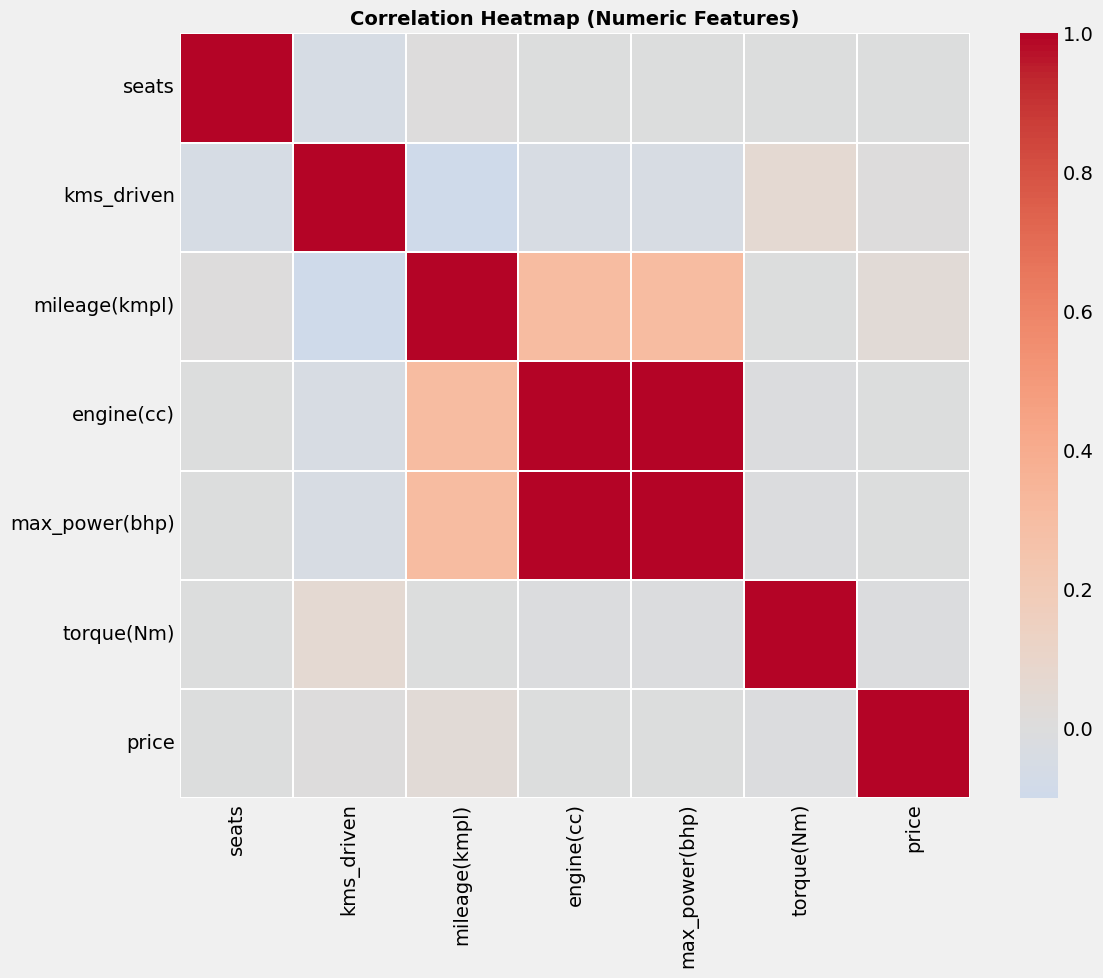

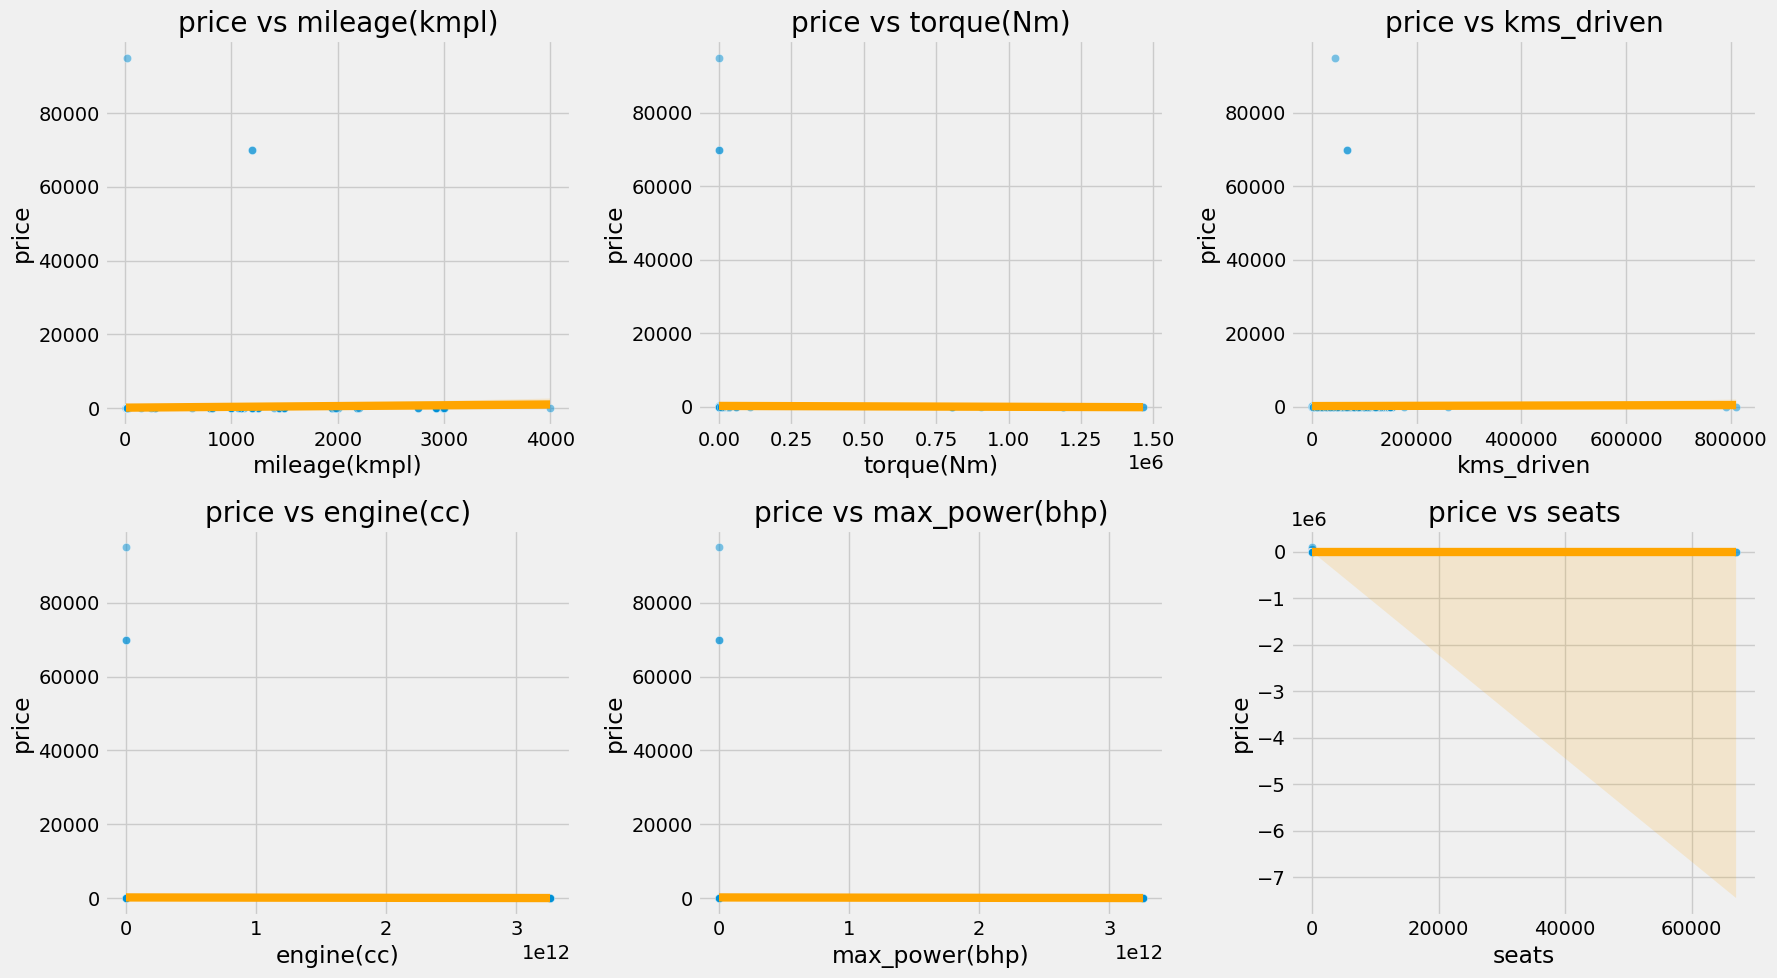

Top absolute correlations with price:
mileage(kmpl)     0.036170
torque(Nm)        0.006467
kms_driven        0.003955
engine(cc)        0.003199
max_power(bhp)    0.003199
seats             0.001549
Name: price, dtype: float64


In [4]:
# Numeric correlation heatmap (including target)
num_cols = cars_df.select_dtypes(include=[np.number]).columns
corr = cars_df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, linewidths=0.3)
plt.title('Correlation Heatmap (Numeric Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Scatterplots vs price for top correlated features (excluding price itself)
target = 'price'
correlations = corr[target].drop(target).abs().sort_values(ascending=False)
key_features = list(correlations.head(6).index)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flat
for ax, col in zip(axes, key_features):
    sns.scatterplot(data=cars_df, x=col, y=target, ax=ax, alpha=0.5)
    sns.regplot(data=cars_df, x=col, y=target, ax=ax, scatter=False, color='orange')
    ax.set_title(f'{target} vs {col}')

plt.tight_layout()
plt.show()

print('Top absolute correlations with price:')
print(correlations.head(10))

In [5]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   car_name            1553 non-null   object 
 1   registration_year   1553 non-null   object 
 2   insurance_validity  1553 non-null   object 
 3   fuel_type           1553 non-null   object 
 4   seats               1553 non-null   int64  
 5   kms_driven          1553 non-null   int64  
 6   ownsership          1553 non-null   object 
 7   transmission        1553 non-null   object 
 8   manufacturing_year  1553 non-null   object 
 9   mileage(kmpl)       1550 non-null   float64
 10  engine(cc)          1550 non-null   float64
 11  max_power(bhp)      1550 non-null   float64
 12  torque(Nm)          1549 non-null   float64
 13  price               1553 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 170.0+ KB


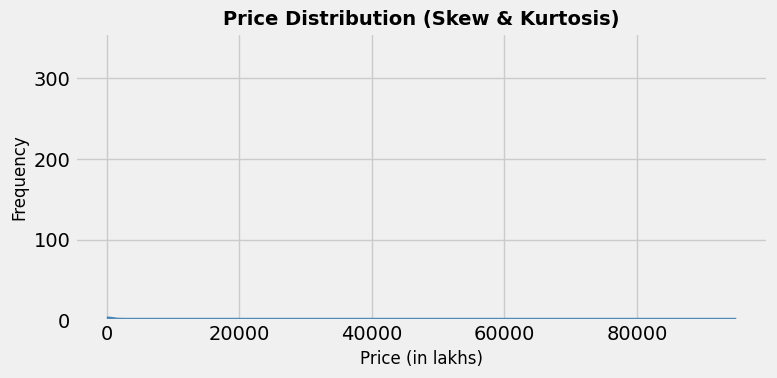

Skewness: 23.50639293899196
Kurtosis: 564.2376133644871


In [6]:
# Price distribution (skew evaluation)
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=cars_df, x='price', kde=True, ax=ax, color='steelblue')
ax.set_title('Price Distribution (Skew & Kurtosis)', fontsize=14, fontweight='bold')
ax.set_xlabel('Price (in lakhs)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()
print('Skewness:', cars_df['price'].skew())
print('Kurtosis:', cars_df['price'].kurtosis())

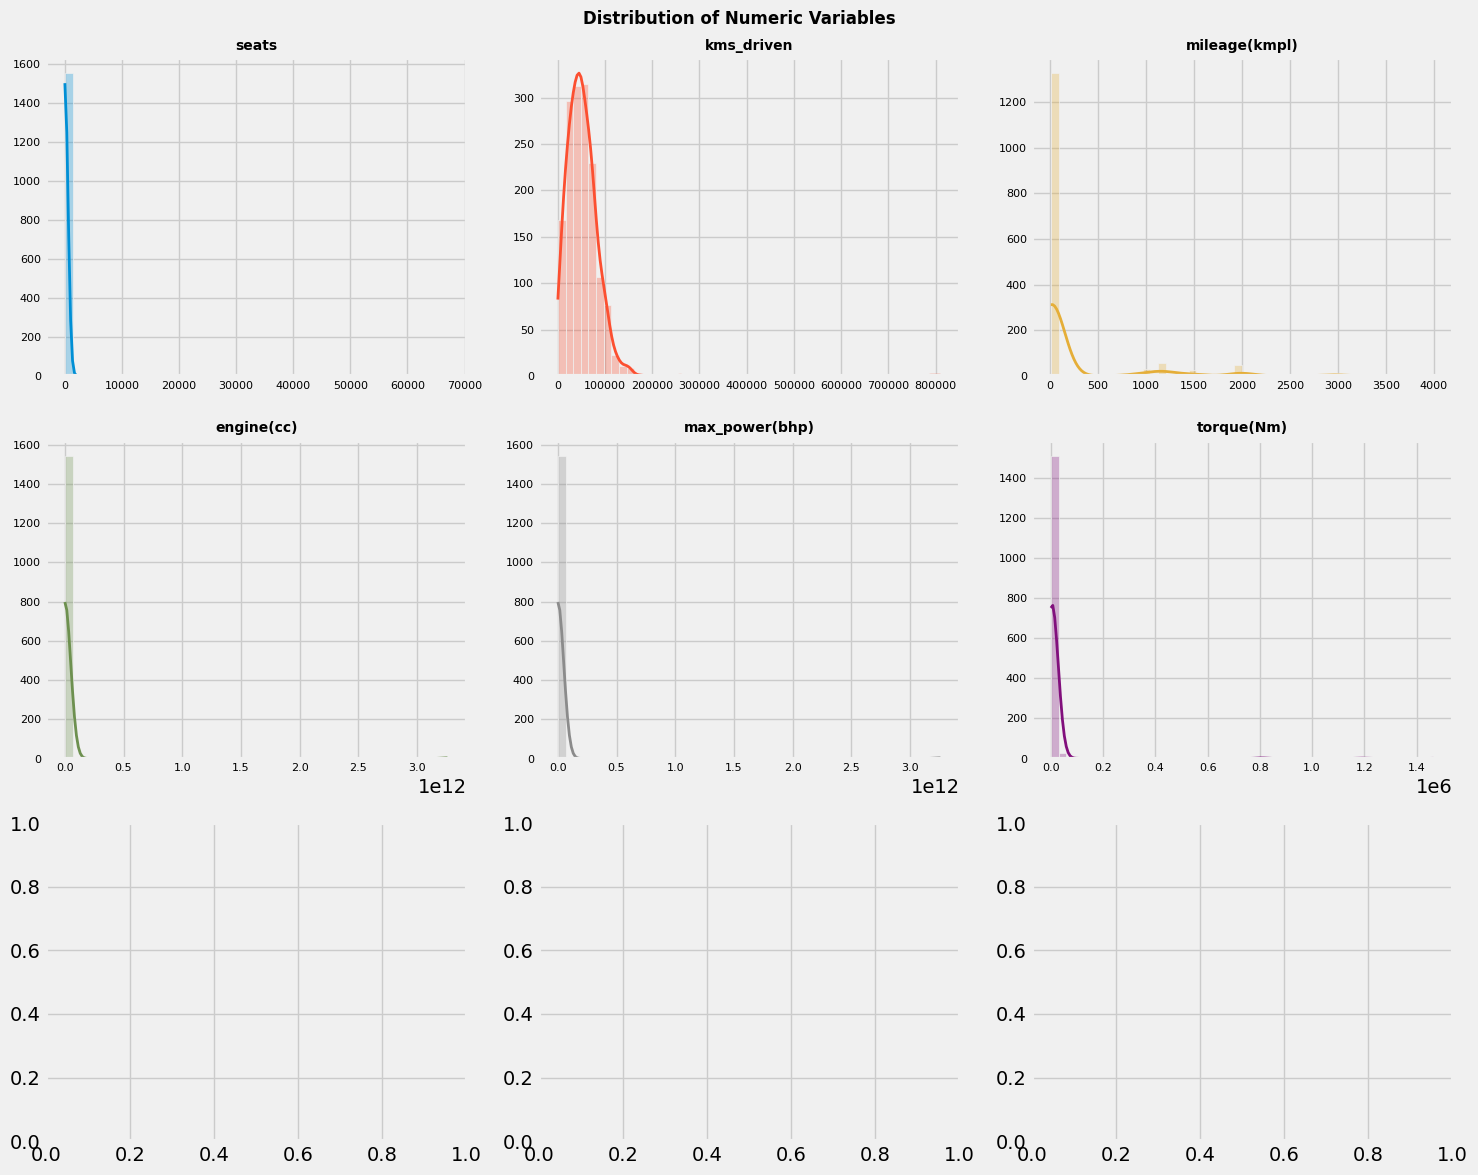

In [8]:
# Distribution of numeric variables
numeric_columns = cars_df.select_dtypes(include=[np.number]).columns
numeric_columns = numeric_columns.drop('price')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.histplot(
        data=cars_df,
        x=column,
        stat='count',
        kde=True,
        bins=50,
        color=(list(plt.rcParams['axes.prop_cycle']) * 2)[i]['color'],
        line_kws={'linewidth': 2},
        alpha=0.3,
        ax=axes[i]
    )
    axes[i].set_title(column, fontsize=10, fontweight='bold')
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

fig.tight_layout()
plt.subplots_adjust(top=0.94)
fig.suptitle('Distribution of Numeric Variables', fontsize=12, fontweight='bold')
plt.show()

In [10]:
# Categorical price stratification
# Key categorical variables show structured price differentiation. We report summary stats and visualize
# median price for dominant categories. Fuel type and transmission illustrate clear value tiers.
cars_df['brand'] = cars_df['car_name'].str.split().str[1].fillna('Unknown')
cat_cols = ['brand', 'fuel_type', 'transmission', 'ownsership']
price_summary = cars_df.groupby(cat_cols)['price'].median().reset_index()
price_summary.head()

,brand,fuel_type,transmission,ownsership,price
0,Audi,Diesel,2016,1968 cc,15.30
1,Audi,Diesel,Automatic,First Owner,20.00
2,Audi,Diesel,Automatic,Second Owner,37.40
3,Audi,Petrol,2014,1984 cc,8.00
4,Audi,Petrol,Automatic,First Owner,35.49


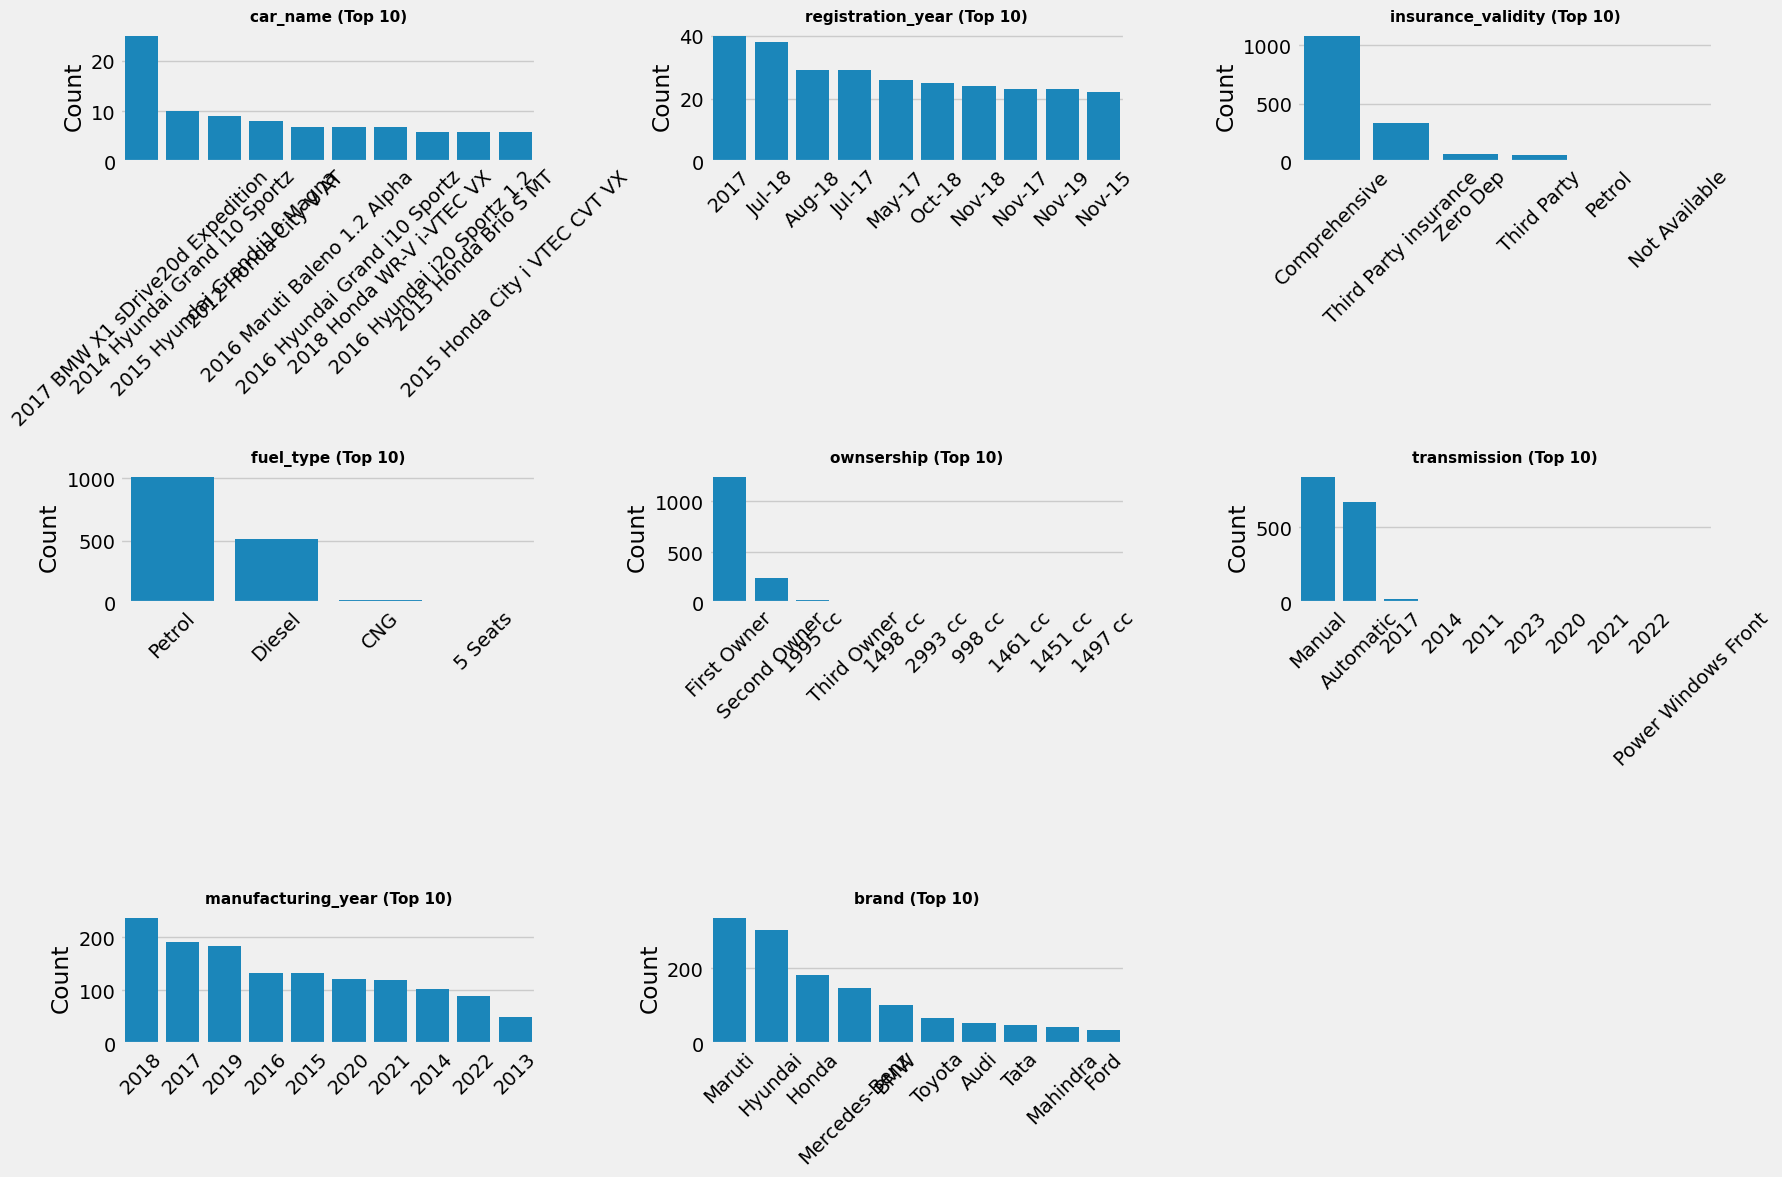

In [12]:
# Bar charts for categorical variables (top categories only)
cat_cols = cars_df.select_dtypes(include=['object', 'category']).columns.tolist()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flat
for i, col in enumerate(cat_cols[:9]):
    order = cars_df[col].value_counts().head(10).index
    sns.countplot(
        data=cars_df[cars_df[col].isin(order)],
        x=col,
        order=order,
        ax=axes[i],
        palette=None,
        hue=None,
        legend=False
    )
    axes[i].set_title(f'{col} (Top 10)', fontsize=11, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

for j in range(i + 1, 9):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

OUTLIER ANALYSIS - NUMERIC FEATURES


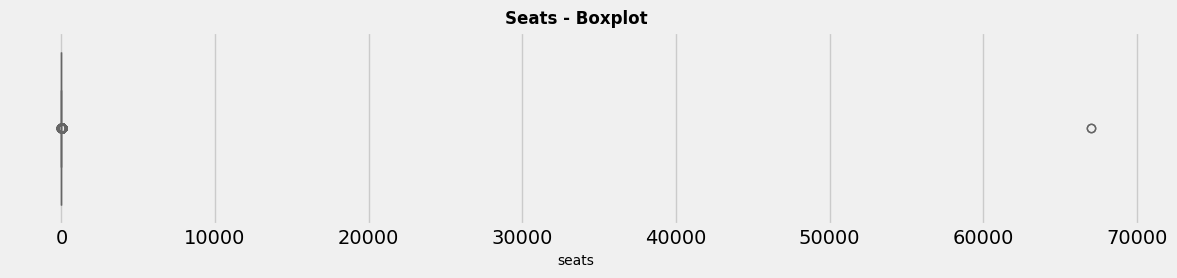


Summary Statistics for Seats:
 count     1553.000000
mean        91.480361
std       2403.424060
min          4.000000
25%          5.000000
50%          5.000000
75%          5.000000
max      67000.000000
Name: seats, dtype: float64
------------------------------------------------------------


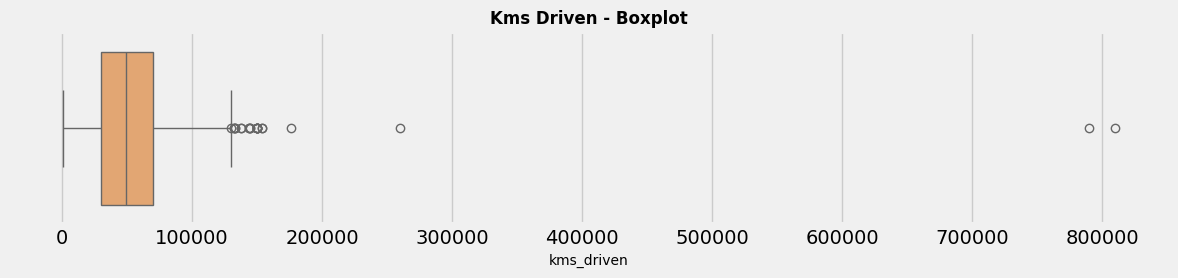


Summary Statistics for Kms Driven:
 count      1553.000000
mean      52841.931101
std       40067.800347
min         620.000000
25%       30000.000000
50%       49134.000000
75%       70000.000000
max      810000.000000
Name: kms_driven, dtype: float64
------------------------------------------------------------


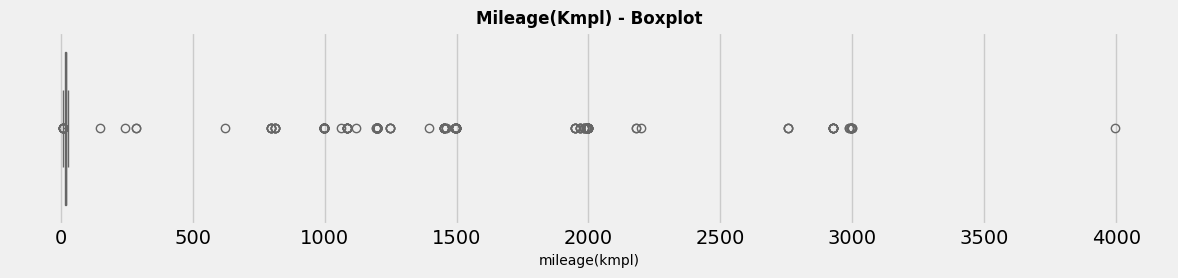


Summary Statistics for Mileage(Kmpl):
 count    1550.000000
mean      236.927277
std       585.964295
min         7.810000
25%        16.342500
50%        18.900000
75%        22.000000
max      3996.000000
Name: mileage(kmpl), dtype: float64
------------------------------------------------------------


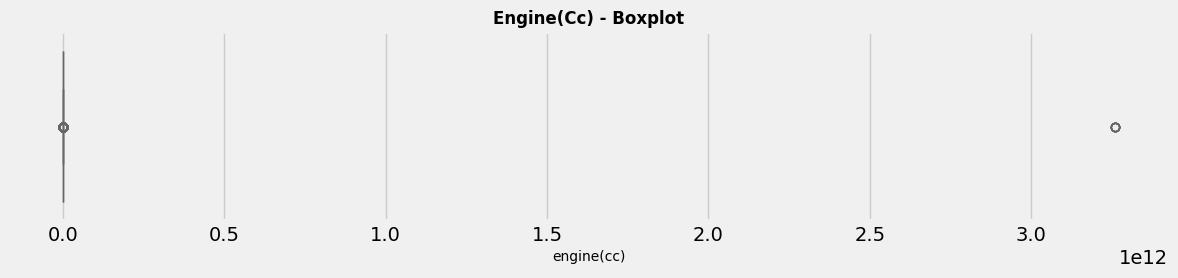


Summary Statistics for Engine(Cc):
 count    1.550000e+03
mean     1.472472e+10
std      2.186542e+11
min      5.000000e+00
25%      1.197000e+03
50%      1.462000e+03
75%      1.995000e+03
max      3.260000e+12
Name: engine(cc), dtype: float64
------------------------------------------------------------


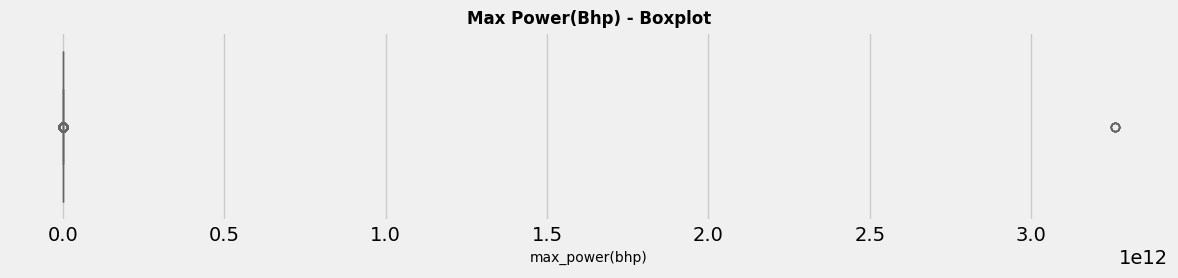


Summary Statistics for Max Power(Bhp):
 count    1.550000e+03
mean     1.472472e+10
std      2.186542e+11
min      5.000000e+00
25%      1.197000e+03
50%      1.462000e+03
75%      1.995000e+03
max      3.260000e+12
Name: max_power(bhp), dtype: float64
------------------------------------------------------------


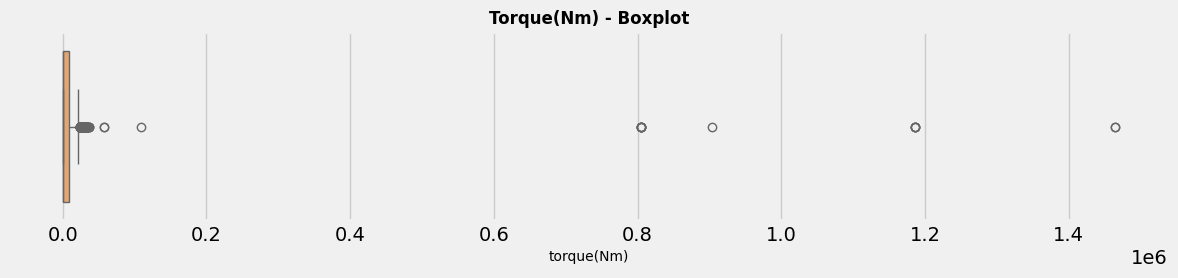


Summary Statistics for Torque(Nm):
 count    1.549000e+03
mean     1.423989e+04
std      9.666241e+04
min      5.000000e+00
25%      4.000000e+02
50%      1.173000e+03
75%      8.850000e+03
max      1.464800e+06
Name: torque(Nm), dtype: float64
------------------------------------------------------------


In [13]:
# Outlier Analysis (Numeric Features)

def boxplot_summary(df, column, title):
    plt.figure(figsize=(12, 3))
    sns.boxplot(x=df[column], color='sandybrown')
    plt.title(f'{title} - Boxplot', fontsize=12, fontweight='bold')
    plt.xlabel(column, fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f'\nSummary Statistics for {title}:\n', df[column].describe())
    print('-' * 60)

numeric_columns = cars_df.select_dtypes(include=['float64', 'int']).columns.drop('price')
print('='*60)
print('OUTLIER ANALYSIS - NUMERIC FEATURES')
print('='*60)
for col in numeric_columns:
    boxplot_summary(cars_df, col, col.replace('_', ' ').title())

# Modeling


Model development is handled in `used-cars-multiple-regression.ipynb`, which consumes the insights documented here. This EDA notebook intentionally stops before model fitting to keep responsibilities separated.

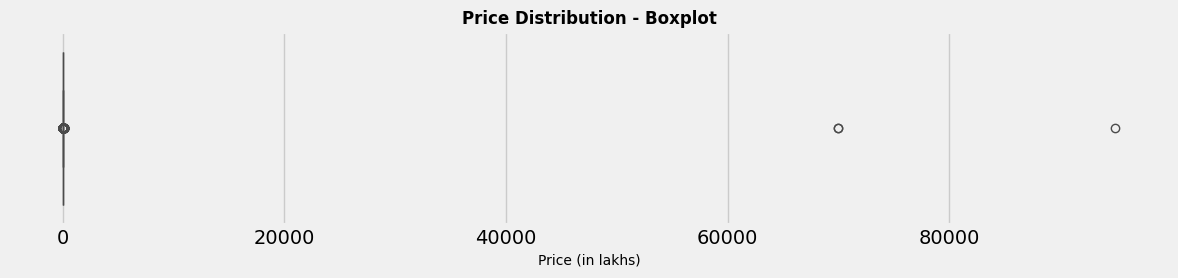

TARGET VARIABLE: PRICE

Summary Statistics:
 count     1553.000000
mean       166.141494
std       3478.855090
min          1.000000
25%          4.660000
50%          7.140000
75%         17.000000
max      95000.000000
Name: price, dtype: float64


In [14]:
# Target Variable (Price) Boxplot
plt.figure(figsize=(12, 3))
sns.boxplot(x=cars_df['price'], color='steelblue')
plt.title('Price Distribution - Boxplot', fontsize=12, fontweight='bold')
plt.xlabel('Price (in lakhs)', fontsize=10)
plt.tight_layout()
plt.show()

print('='*60)
print('TARGET VARIABLE: PRICE')
print('='*60)
print('\nSummary Statistics:\n', cars_df['price'].describe())

# Evaluation


Model evaluation metrics (RMSE, MAE, R², residual diagnostics) are computed in the regression notebook after training. No quantitative evaluation occurs in this EDA-focused notebook.

# Conclusions


- Price is right-skewed with substantial high-end outliers; log transformation is recommended before modeling.
- Usage (kilometers driven), vehicle age, and engine output explain most variance among numeric drivers.
- Brand, fuel type, and transmission create distinct price tiers; encoding/segmenting by these categories should aid modeling.
- Outlier inspection highlights a handful of extreme mileage and power records worth capping or removing in preprocessing.
- Clean data ingestion with standardized naming enables the regression notebook to focus solely on modeling and evaluation.